In [17]:
%pip install pandas numpy matplotlib

# Import our primary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A setting to make our plots look nicer
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Libraries imported successfully!


In [18]:
# Load the dataset
# You will need to change the filename to match the one you downloaded.
# Try to read with default options, but skip bad lines if parsing fails
file_path = '../data/cumulative_2025.10.04_00.14.27.csv'
koi_data = pd.read_csv(file_path, on_bad_lines='skip', engine='python')

print("Data loaded successfully!")

Data loaded successfully!


In [19]:
# Display the first 5 rows of the table
koi_data.head()

,# This file was produced by the NASA Exoplanet Archive http://exoplanetarchive.ipac.caltech.edu
0,# Sat Oct 4 00:14:27 2025
1,#
2,# COLUMN kepid: KepID
3,# COLUMN kepoi_name: KOI Name
4,# COLUMN kepler_name: Kepler Name


In [21]:
# Check the values in our target column
# Make sure cell 4 (which reloads koi_data with the correct header) has been run before this cell
koi_data['koi_disposition'].value_counts()

KeyError: 'koi_disposition'

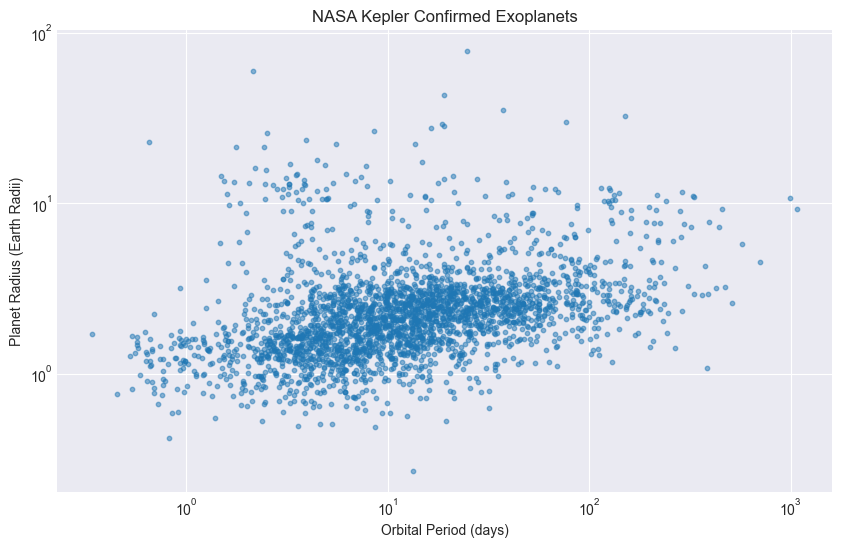

In [22]:
# Reload the CSV with the correct header row (skip comment lines)
# The actual data header is likely at line 51 (0-based index), so header=51
koi_data = pd.read_csv(file_path, comment='#', header=0, engine='python')

# Let's plot Orbital Period vs. Planet Radius for CONFIRMED exoplanets
confirmed_planets = koi_data[koi_data['koi_disposition'] == 'CONFIRMED']

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(confirmed_planets['koi_period'], confirmed_planets['koi_prad'], alpha=0.5, s=10)

# Use a log scale for better visibility of the distribution
plt.xscale('log')
plt.yscale('log')

# Add labels and a title
plt.title('NASA Kepler Confirmed Exoplanets')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Planet Radius (Earth Radii)')

# Show the plot
plt.show()

In [23]:
# Select a subset of promising features
features = [
    'koi_period',        # Orbital Period (days)
    'koi_duration',      # Transit Duration (hours)
    'koi_depth',         # Transit Depth (parts per million)
    'koi_prad',          # Planetary Radius (Earth radii)
    'koi_steff',         # Stellar Effective Temperature (Kelvin)
    'koi_slogg',         # Stellar Surface Gravity (log10(cm/s^2))
    'koi_srad',          # Stellar Radius (Solar radii)
    'koi_disposition'    # The target label we want to predict
]

# Create a new DataFrame with only these features
df_clean = koi_data[features].copy()

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   koi_period       9564 non-null   float64
 1   koi_duration     9564 non-null   float64
 2   koi_depth        9201 non-null   float64
 3   koi_prad         9201 non-null   float64
 4   koi_steff        9201 non-null   float64
 5   koi_slogg        9201 non-null   float64
 6   koi_srad         9201 non-null   float64
 7   koi_disposition  9564 non-null   object 
dtypes: float64(7), object(1)
memory usage: 597.9+ KB


In [24]:
# Filter out the 'CANDIDATE' entries
df_clean = df_clean[df_clean['koi_disposition'] != 'CANDIDATE']

# Create a numerical mapping for our target
disposition_map = {'CONFIRMED': 1, 'FALSE POSITIVE': 0}
df_clean['koi_disposition'] = df_clean['koi_disposition'].map(disposition_map)

# Check the new distribution
df_clean['koi_disposition'].value_counts()

koi_disposition
0    4839
1    2746
Name: count, dtype: int64

In [25]:
# Drop rows with any missing values
df_clean = df_clean.dropna()

# Verify that there are no more missing values
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7326 entries, 0 to 9563
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   koi_period       7326 non-null   float64
 1   koi_duration     7326 non-null   float64
 2   koi_depth        7326 non-null   float64
 3   koi_prad         7326 non-null   float64
 4   koi_steff        7326 non-null   float64
 5   koi_slogg        7326 non-null   float64
 6   koi_srad         7326 non-null   float64
 7   koi_disposition  7326 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 515.1 KB


In [26]:
if 'df_clean' not in locals():
	print("Variable 'df_clean' is not defined. Please run the previous data cleaning cells first.")
else:
	# 'X' contains all our feature columns
	X = df_clean.drop('koi_disposition', axis=1)

	# 'y' contains the target column
	y = df_clean['koi_disposition']

In [27]:
from sklearn.model_selection import train_test_split

# Check if X and y are defined
if 'X' not in locals() or 'y' not in locals():
	print("Variables X and y are not defined. Please run the cell that defines X and y (cell 8) first.")
else:
	# Split the data into training and testing sets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

	# stratify=y ensures that the proportion of confirmed planets and false positives is the same in both the train and test sets.
	# random_state=42 ensures we get the same split every time we run the code.

	print(f"Training data shape: {X_train.shape}")
	print(f"Testing data shape: {X_test.shape}")

Training data shape: (5128, 7)
Testing data shape: (2198, 7)


In [28]:
from sklearn.ensemble import RandomForestClassifier

# Check if X_train and y_train are defined
if 'X_train' not in locals() or 'y_train' not in locals():
	print("Variables X_train and y_train are not defined. Please run the cell that splits the data (cell 9) first.")
else:
	# Create the model instance
	# n_estimators is the number of "trees" in our forest. 100 is a good starting point.
	model = RandomForestClassifier(n_estimators=100, random_state=42)

	# Train the model on the training data
	model.fit(X_train, y_train)

	print("Model training complete!")

Model training complete!


In [29]:
from sklearn.metrics import accuracy_score, classification_report

# Use the trained model to make predictions on the test set
predictions = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\n---------------------------------------\n")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=['False Positive', 'Confirmed Planet']))

Model Accuracy: 89.26%

---------------------------------------

Classification Report:
                  precision    recall  f1-score   support

  False Positive       0.92      0.91      0.91      1375
Confirmed Planet       0.85      0.87      0.86       823

        accuracy                           0.89      2198
       macro avg       0.88      0.89      0.89      2198
    weighted avg       0.89      0.89      0.89      2198



In [30]:
%pip install joblib

import joblib
import os

# Create a directory to store the model if it doesn't exist
if not os.path.exists('../model'):
    os.makedirs('../model')

# Save the trained model to a file
joblib.dump(model, '../model/exoplanet_model.joblib')

print("Model saved successfully to 'model/exoplanet_model.joblib'")

Note: you may need to restart the kernel to use updated packages.
Model saved successfully to 'model/exoplanet_model.joblib'



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
